## Линейная регрессия Предобработка

### <b><span style='color:#686dec'>Предсказания Стоимости Квартиры</span></b>

#### Данные из Москвы


- В предыдущем модуле **мы сделали предобработку** данных о квартирах, выставленных на продажу
- Две важные обработки для линейных моделей; `стандартизация` и уборка `мультиколлиальных` фичей
- Данные готовы для построения регрессионной модели
- Попробуем предсказать цену на квартиры с помощью нескольких признаков квартиры

### Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Читаем данные

- Подгрузим данные и постмотрим на первые строки 

In [3]:
#Подгрузим файл и посмотрим на его пкрвые строки
data = pd.read_csv('data_flats2.csv.xls',sep=';')
data.head()

,id,full_sq,life_sq,floor,preschool_education_centers_raion,school_education_centers_raion,school_education_centers_top_20_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,...,shopping_centers_raion,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,mkad_km,bulvar_ring_km,kremlin_km,price_doc
0,1,43,27.0,4.0,5,5,0,0,7,3,...,16,1.131260,0.145700,0.177975,2.158587,0.600973,1.422391,13.675657,15.156211,5850000
1,2,34,19.0,3.0,5,8,0,0,6,1,...,3,0.635053,0.147754,0.273345,0.550690,0.065321,9.503405,8.132640,8.698054,6000000
2,3,43,29.0,2.0,4,7,0,0,5,1,...,0,1.445960,0.049102,0.158072,0.374848,0.453172,5.604800,8.054252,9.067885,5700000
3,4,89,50.0,9.0,9,10,0,0,17,6,...,11,0.963802,0.179441,0.236455,0.078090,0.106125,2.677824,18.309433,19.487005,13100000
4,5,77,77.0,4.0,7,9,0,2,25,2,...,10,0.688859,0.247901,0.376838,0.258289,0.236214,11.616653,0.787593,2.578671,16331452


- Также обязательно запрашиваем список переменных с их типами
- заодно посмотрим сколько у нас пропусков в данных 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30469 entries, 0 to 30468
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     30469 non-null  int64  
 1   full_sq                                30469 non-null  int64  
 2   life_sq                                24086 non-null  float64
 3   floor                                  30302 non-null  float64
 4   preschool_education_centers_raion      30469 non-null  int64  
 5   school_education_centers_raion         30469 non-null  int64  
 6   school_education_centers_top_20_raion  30469 non-null  int64  
 7   university_top_20_raion                30469 non-null  int64  
 8   sport_objects_raion                    30469 non-null  int64  
 9   additional_education_raion             30469 non-null  int64  
 10  culture_objects_top_25_raion           30469 non-null  int64  
 11  sh

- У нас 20 признаков, один из них `id` (не имеет смысловой нагрузки)
- Один из признаков, наша независимая переменная `price_doc` (цена квартиры которую будем предсказывать)
- Сразу можно еще отметить наличие пропусков

### Визуализация пропусков

- Один из признаков, наша независимая переменная `price_doc` (цена квартиры), которую мы будем предсказывать 
- Точно видем что есть пропуски, так как количество наблюдении разное у разных переменных

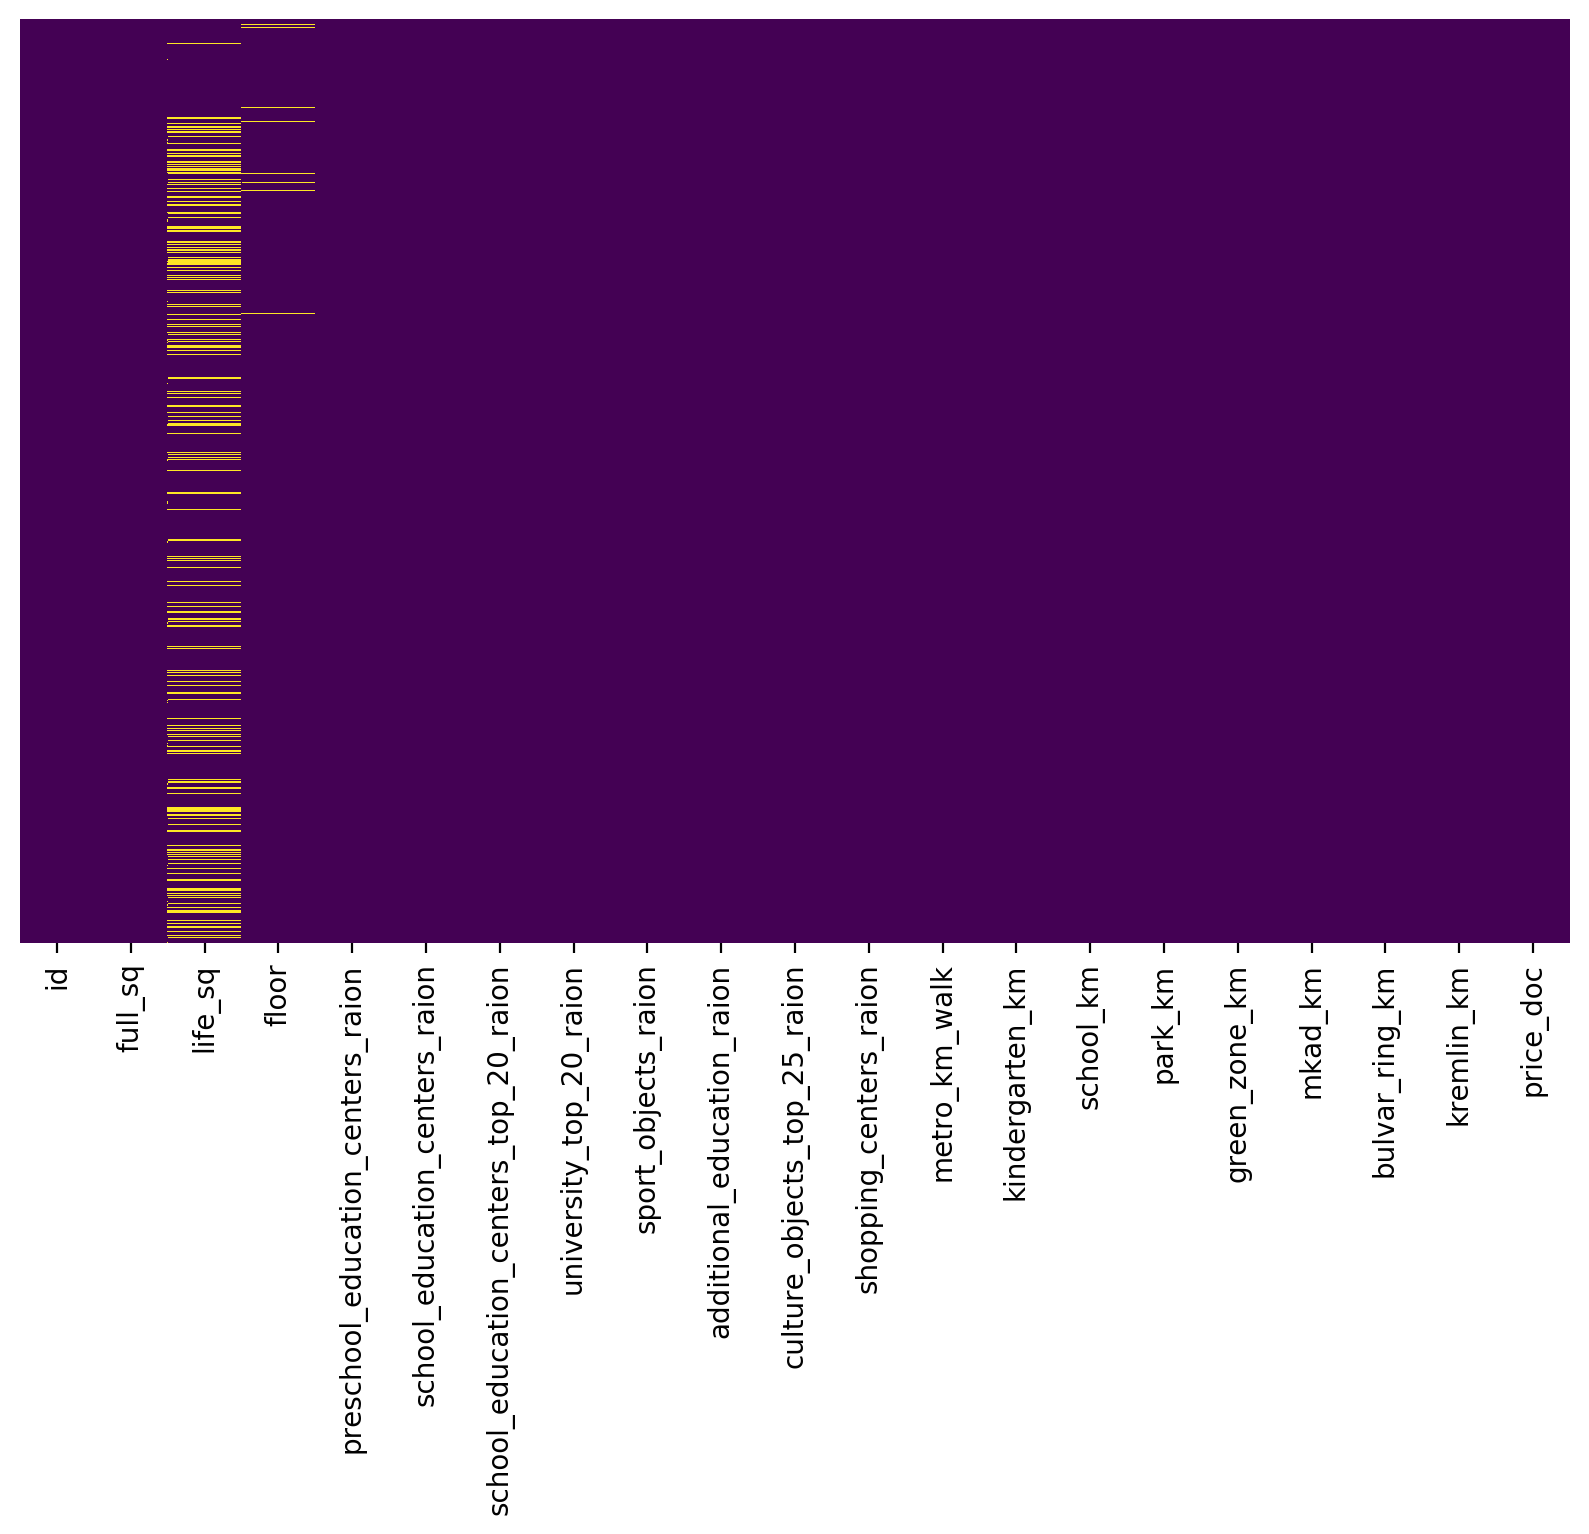

In [6]:
# data.isnull().sum()
import seaborn as sns

fix,ax = plt.subplots(figsize=(10,6))
sns_heatmap = sns.heatmap(data.isnull(),
                          yticklabels=False,
                          cbar=False,cmap='viridis')

- **Фиолетовым** показаны заполненные ячейки,**желтые** пропущенные значения
- У нас пропуски по сути только в одном признаке; `life_sq` (площадь жилой площади), 
- Не будем использовать ее в модели так как доля не маленькая

### Оценим распределение целевой переменной
- Посмотрим на распределение нашей целевой переменной, что бы понять какие значения мы будем предсказывать

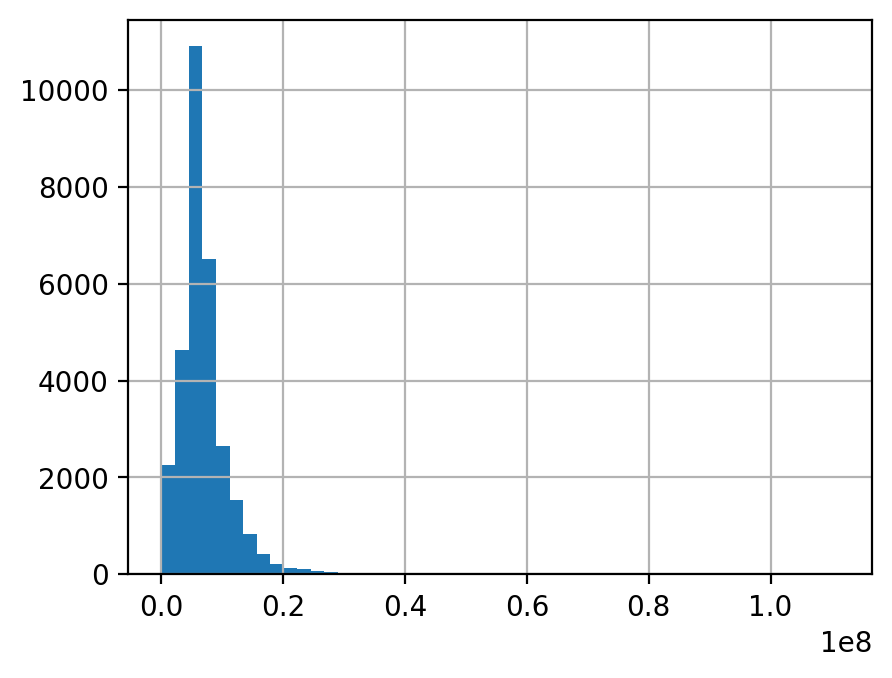

In [7]:
data.price_doc.hist(bins=50)
plt.show()

- У нашего распределения есть проблемма; слишком сильный перепад. 
- Много квартир в среднем сегменте, но не очень много дорогих квартир
- Применим часто используюемую предобработку; **логарифмическая** преоброжение
- Это делаеися для того чтобы уменьшить перепад и сгладить хвостовые данные

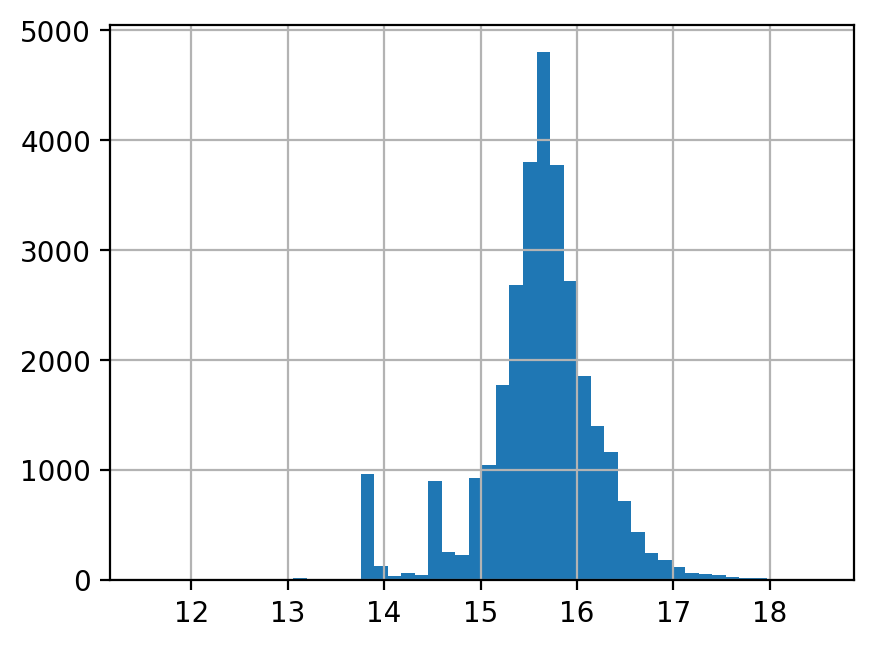

In [8]:
data['price_doc'] = data['price_doc'].apply(lambda x: np.log(x+1))
data['price_doc'].hist(bins=50)
plt.show()

### Построим матрицу корреляции для признаков

- Дальше будем отбирать признаки
- Нужно проверить, есть ли мультиколлинеарности (сильной взаимосвязи между независимыми признаками) в данных
- Посмотрим на матрицу корреляции для наших признаков

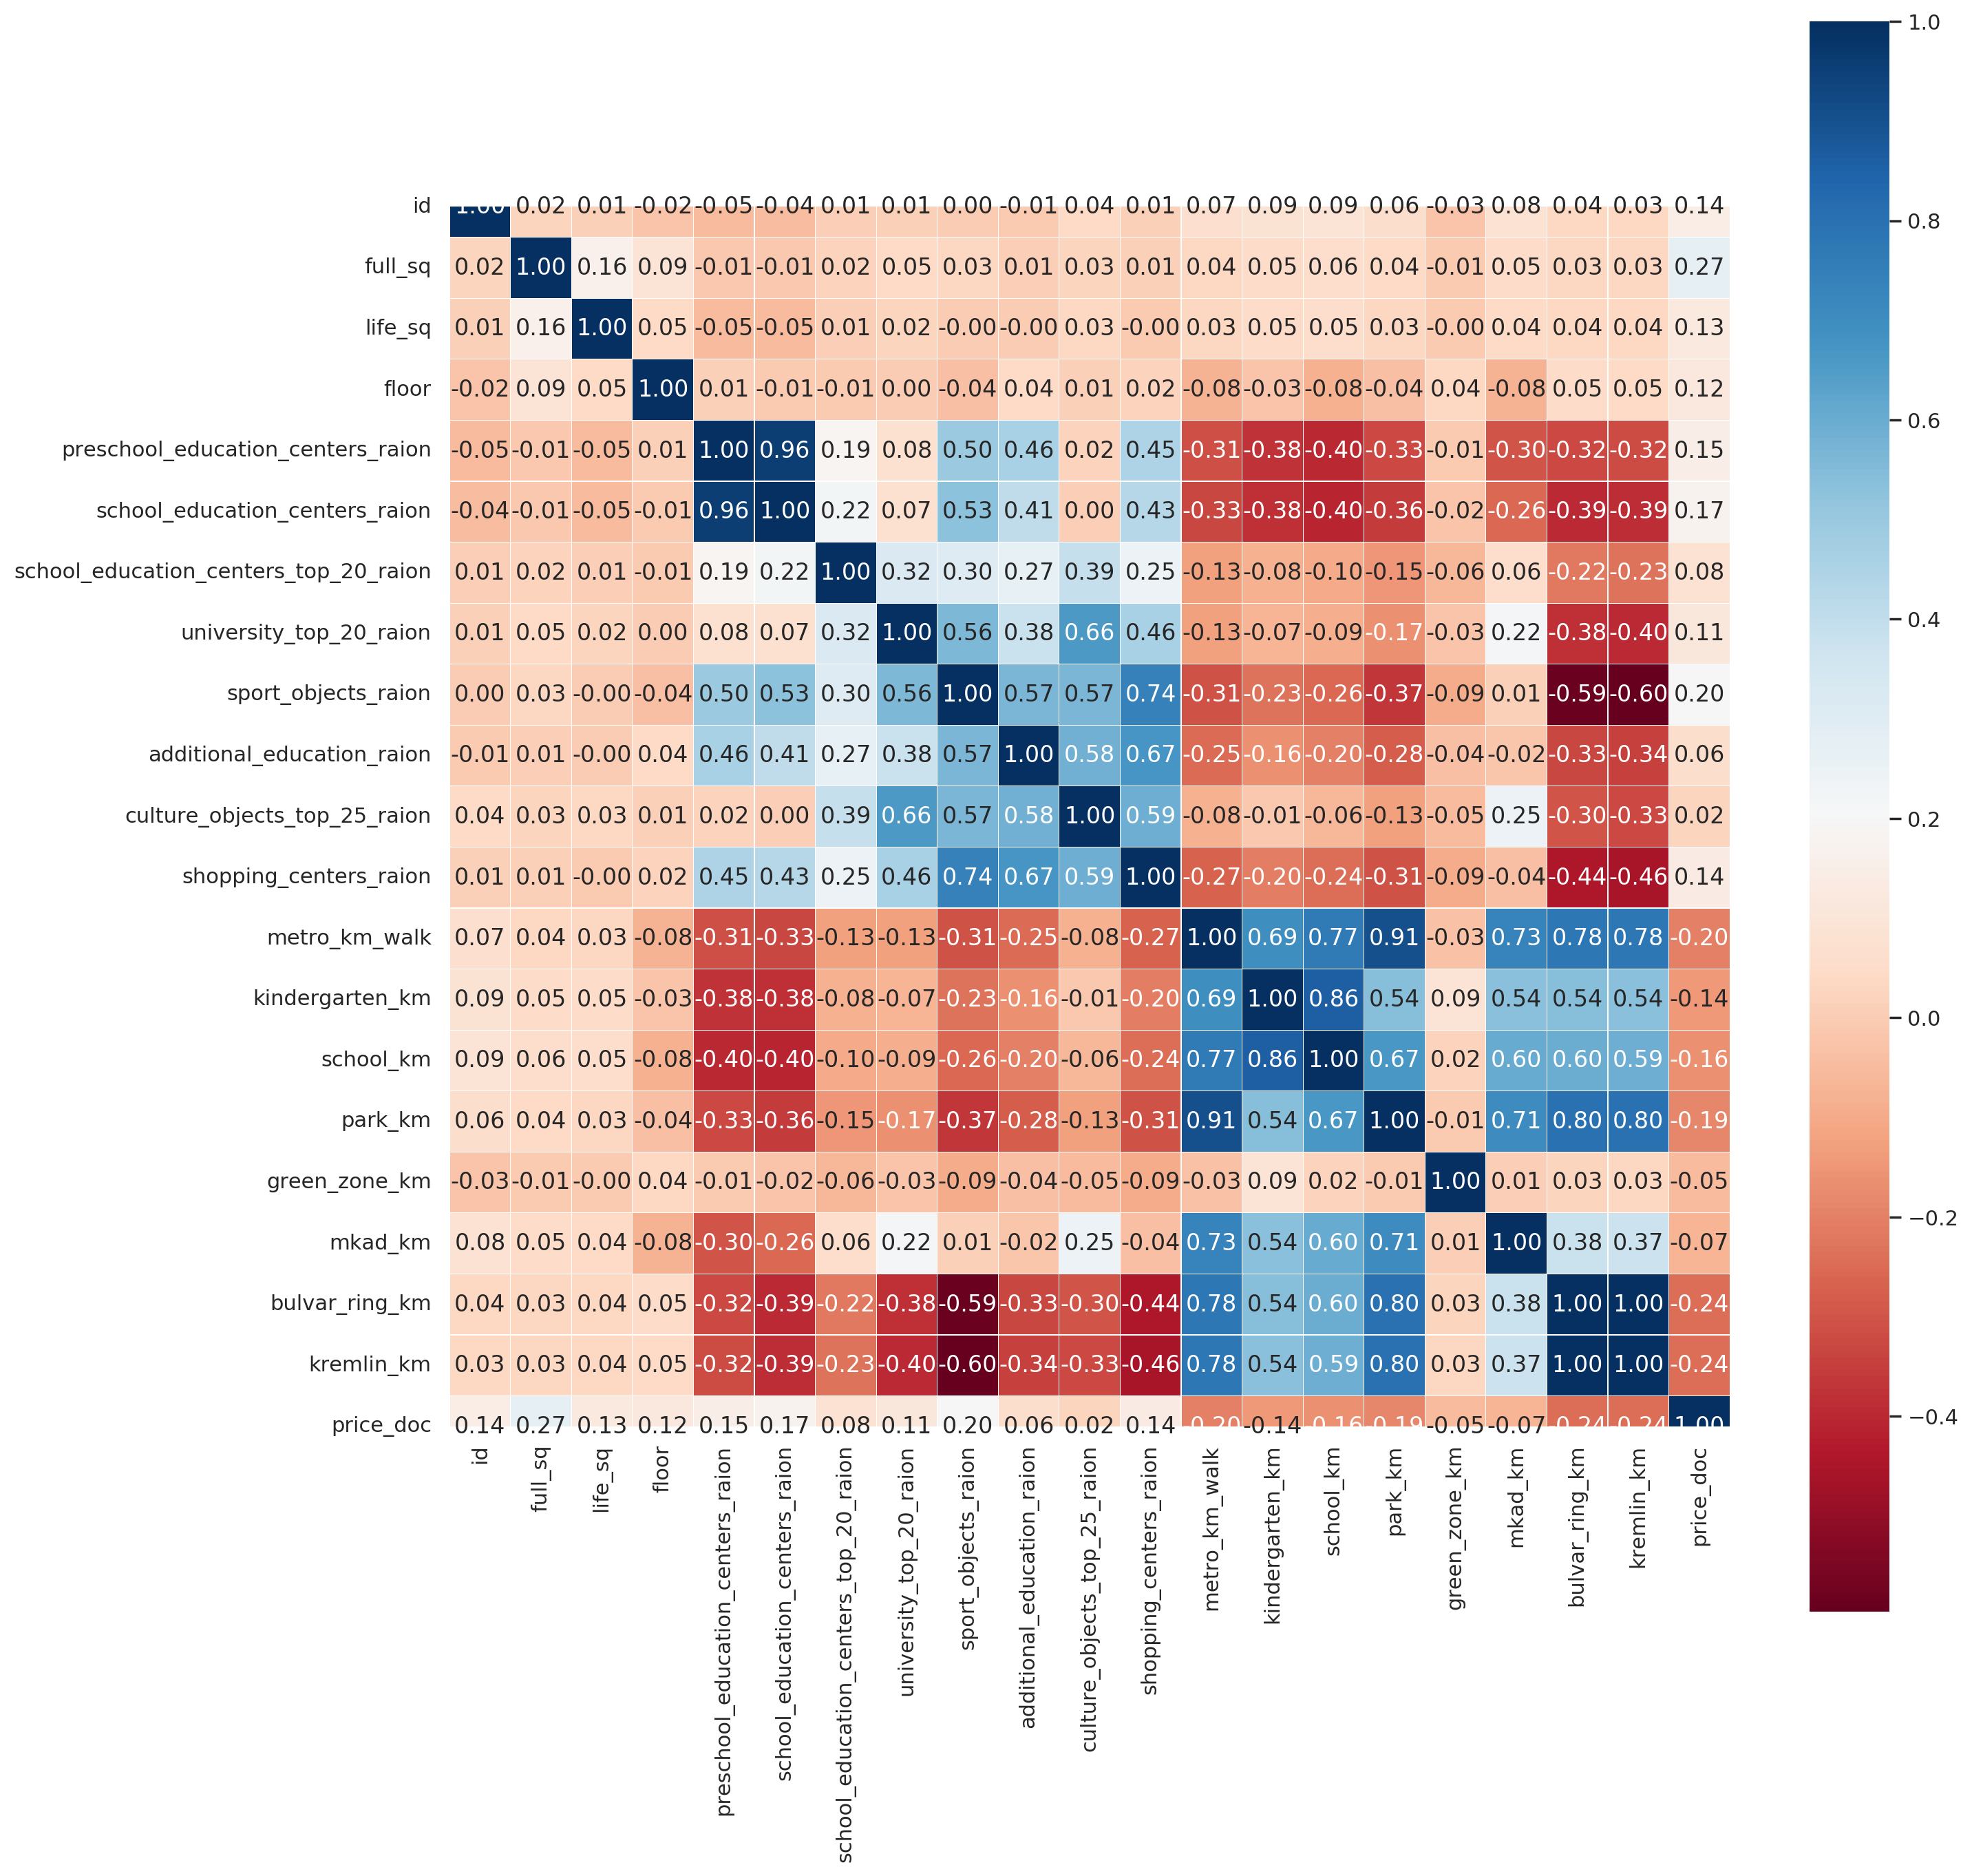

In [9]:
sns.set(font_scale=1)
plt.subplots(figsize=(15,15))
sns.heatmap(data.corr(),square=True,annot=True,
            fmt=".2f",lw=0.1,cmap='RdBu')

Признаки у которых сильная взаимосвязь:

- Количество школ и количество детских садов `preschool_education_centres_raion` `school_education_centres_raion` (оставляем `school_education_centres_raion`)
- Расстояние до школ и расстояния до детских садов `kindergarten_km` `school_km` (оставляем `school_km`)
- Расстояния до парка и до метро `park_km` `metro_km_walk` (оставляем `metro_km_walk`)
- Расстояния до кремля и до бульварного когьца `bulvar_ring_km` `kremlin_km` (оставляем `bulvar_ring_km`)

### Убираем признаки

- По итогам **визуализации просусков** и построения **матрицы коррелиальности**
- Также убираем строки/ряда где есть хоть один пропуск

In [2]:
# Признаки которые мы будем убирать
drop_columns = ['preschool_education_centers_raion',
                'kindergarten_km','park_km','kremlin_km',
                'life_sq','id']

data.drop(drop_columns,axis=1,inplace=True)
data = data.dropna()

### <b><span style='color:#686dec'>Задание</span></b>

#### <b>Задание <span style='color:#686dec'>3.5.1</span></b> 

Удалите строки, где есть хотя бы один пропуск. Обучите линейную регрессию, взяв тестовую выборку размера 0.2, random_state=77.Нормализуйте отобранные признаки для тестовой и для обучающей выборки отдельно(!) с помощью функции RobustScaler() (функция, которая подобна известным вам методам нормализации, однако использует медианы и квантили для вычисления, поэтому не чувствительна к выбросам и может приводить к лучшим результатам). Вычислите MSE , ответ запишите с точностью до сотых. Не забудьте, что id не несет никакой содержательной информации, поэтому не надо брать его в качестве предиктора! Также не забудьте, что мы логарифмировали зависимую переменную, а значит при подсчете MSE необходимо найти экспоненциальную функцию от ! Округлите ответ до целых.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

def evaluate(target):
    
    y = data['price_doc'].copy()
    X = data.drop(['price_doc'],axis=1)

# разделяем на тренировачную и тестовую выборку
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        random_state=77,
                                                        test_size=0.2)

    # Нормализируем признаки для тестовой и обучающей выборки отдельно
    scaler = RobustScaler()
    X_train_sca = scaler.fit_transform(X_train)
    X_test_sca = scaler.transform(X_test)

    # Тренируем модель
    model = LinearRegression()
    model.fit(X_train_sca,y_train)
    y_pred_train = model.predict(X_train_sca)
    y_pred_test = model.predict(X_test_sca)

    # Вычисляем MSE (незабываем учитывать трансформацию)
    error_mse = np.round(MSE(np.exp(y_test) - 1, 
                             np.exp(y_pred_test) - 1))
    print(error_mse)
    
evaluate('price_doc')

16818684371715.0
